In [1]:
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


import torch
from torch import nn
import torchvision
from torchinfo import summary
import torchvision.transforms.v2 as T2
from torch.utils.data import DataLoader, Dataset, Subset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"running on {device}")

running on cuda


In [2]:
def seeds(seed_no:int=42):
    random.seed(seed_no)
    torch.manual_seed(seed_no)
    torch.cuda.manual_seed(seed_no)

seeds()

In [3]:
images_path = Path("/kaggle/input/face-images-with-marked-landmark-points/face_images.npz")
keypoints_path = Path("/kaggle/input/face-images-with-marked-landmark-points/facial_keypoints.csv")

In [4]:
images = np.load(images_path) 
images = images[images.files[0]] # get the data
images = np.moveaxis(images, -1, 0)  # move the last index to the first, changes (96,96,7049) -> (7049, 96, 96)
images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1) # add color channel (7049, 1, 96, 96)
images.shape

<ipython-input-4-b6bbf95d303a>:2: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  images = images[images.files[0]] # get the data


(7049, 96, 96, 1)

In [5]:
type(images[0])

numpy.ndarray

### plot random images

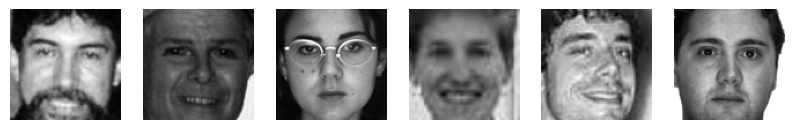

In [6]:
def plot (img:np.ndarray, ax):
    ax.imshow(img, cmap="gray") 
    ax.axis(False)

no_images = 6
samples = torch.randperm(len(images))[:no_images]

fig, axs = plt.subplots(nrows=1, ncols=no_images, figsize=(10,5))
for i in range(len(samples)):
    plot(images[samples[i]], ax=axs[i])

### get landmarks


In [7]:
landmarks_df = pd.read_csv(keypoints_path)
landmarks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [8]:
# replace NaN's with 0
landmarks_df.fillna(value=0, inplace=True)
landmarks_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,67.402546,31.842551,29.746749,38.632942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,48.265961,67.029093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.426637,79.683921
7045,66.134400,38.365501,30.478626,39.950198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,47.910346,66.626011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.287397,77.983023
7046,66.690732,36.845221,31.666420,39.685042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,49.462572,67.515161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.462572,78.117120
7047,70.965082,39.853666,30.543285,40.772339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,50.754202,66.724988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.065186,79.586447


In [9]:
landmarks = np.array(landmarks_df.values)
landmarks[0]

array([66.03356391, 39.00227368, 30.22700752, 36.4216782 , 59.58207519,
       39.64742256, 73.13034586, 39.96999699, 36.35657143, 37.3894015 ,
       23.45287218, 37.3894015 , 56.95326316, 29.03364812, 80.22712782,
       32.22813835, 40.22760902, 29.0023218 , 16.35637895, 29.64747068,
       44.42057143, 57.06680301, 61.19530827, 79.97016541, 28.61449624,
       77.38899248, 43.3126015 , 72.93545865, 43.13070677, 84.48577444])

In [10]:
def pair_landmarks(landmarks):
    pairs = []
    idx = 0
    while idx < len(landmarks):
        pair = landmarks[idx:idx+2]
        pair = [int(coord) for coord in pair]
        pairs.append(pair)
        idx += 2
    return pairs
    
def draw_landmark_on_image(img, landmark):
    pairs = pair_landmarks(landmark)
    for pair in pairs:
        img = cv2.circle(img.astype(np.uint8), pair, 1, (255,255,255), 1)
    return cv2_imshow(img)

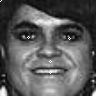

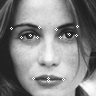

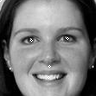

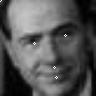

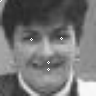

In [11]:
no_images = 5
samples = torch.randperm(len(images))[:no_images]
for i in range(len(samples)):
    axs[i] = draw_landmark_on_image(images[samples[i]], landmarks[samples[i]])

### dataset

In [12]:
class LandmarkDataset(Dataset):
    def __init__ (self, images_dir, landmarks_dir, transforms=None):
        super(LandmarkDataset).__init__()
        self.images = self.load_images(images_dir)
        self.landmarks = self.load_landmarks(landmarks_dir)
        self.transforms = transforms

    def load_images(self, images_dir):
        images = np.load(images_dir) 
        images = images[images.files[0]] # get the data
        images = np.moveaxis(images, -1, 0)  # move the last index to the first, changes (96,96,7049) -> (7049, 96, 96)
        images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1) # add color channel (7049, 1, 96, 96)
        return images

    def load_landmarks(self, landmarks_dir):
        landmarks_df = pd.read_csv(landmarks_dir)
        landmarks_df.fillna(value=0, inplace=True)
        landmarks = np.array(landmarks_df.values)
        return landmarks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float).permute(2,0,1)
        landmarks = torch.tensor(self.landmarks[idx], dtype=torch.float)

        if self.transforms:
            image_trans = self.transforms(image)
            return image, landmarks
            
        return image, landmarks
        

In [13]:
seeds()
dataset = LandmarkDataset(images_path, keypoints_path)

samples = torch.randperm(len(dataset))
train_size = int(0.7 * len(dataset))

train_dataset = Subset(dataset, samples[:train_size])
test_dataset = Subset(dataset, samples[train_size:])

BATCH_SIZE =32
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE)


print(len(train_dataset), len(test_dataset))
print(len(train_dataloader), len(test_dataloader))


<ipython-input-12-c4aaae7320f8>:10: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  images = images[images.files[0]] # get the data


4934 2115
155 67


## make the model
####  inspect vgg16 backbone

In [14]:
weights = torchvision.models.VGG16_Weights.DEFAULT
vgg16_model = torchvision.models.vgg16(weights=weights)
transforms = weights.transforms()

# summary(vgg16_model, input_size=(1,3,224,224), col_names=["input_size","output_size","trainable"], row_settings=["ascii_only","var_names",])

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 214MB/s]


### landmark detection model

In [15]:
class LandmarkDetectionModel(nn.Module):
    def __init__(self, model:torchvision.models.vgg.VGG, in_features=1, hidden_units=64, num_landmarks:int=15):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_features, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # one color chanel
            model.features[1:],
        )
        self.avg_pool = model.avgpool
        self.regression_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=25088, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=num_landmarks*2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.avg_pool(x)
        return self.regression_layer(x)

In [16]:
seeds()
model = LandmarkDetectionModel(model=vgg16_model).to(device)
model

LandmarkDetectionModel(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sequential(
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=Tr

In [17]:
from torch.optim import Adam, SGD
from torch.nn import MSELoss

seeds()
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = MSELoss().to(device)

#### training loop

In [18]:
def accuracy(y_preds, y_logits, mode:str='rmse'):
    if(mode == 'mse'):
        mse = ((y_logits - y_preds)**2).sum().item()
        return mse / len(y_preds)
    elif (mode == 'rmse'):
        rmse = torch.sqrt((y_logits - y_preds)**2).sum().item()
        return rmse / len(y_preds)
    else:
        rmse = torch.sqrt((y_logits - y_preds)**2).sum().item()
        print(f"invalid mode {mode}!!! using RMSE")
        return rmse / len(y_preds)
        

accuracy(torch.rand(1,30), torch.rand(1,30), 'bams')

invalid mode bams!!! using RMSE


8.079423904418945

In [19]:
EPOCHS = 45
history = {'train_loss': [], 'train_acc': [], 'eval_loss': [], 'eval_acc': []}

for epoch in range(EPOCHS):
    train_acc, train_loss = 0,0
    model.train()
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        logits = model(X_train)
        loss = criterion(logits, y_train)
        train_acc += accuracy(logits, y_train)
        train_loss += loss

        optimizer.zero_grad()  # prevent gradients from accumulating
        loss.backward()
        optimizer.step()
    train_acc /= len(train_dataloader)
    train_loss /= len(train_dataloader)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    


    model.eval()
    with torch.inference_mode():
        test_acc, test_loss = 0, 0
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_logits = model(X_test)
            t_loss = criterion(test_logits, y_test)
            test_acc += accuracy(test_logits, y_test)
            test_loss += t_loss

        test_acc /= len(test_dataloader)
        test_loss /= len(test_dataloader)
        history['eval_loss'].append(test_loss)
        history['eval_acc'].append(test_acc)

    print(f"[{epoch + 1}/{EPOCHS}] | train_loss: {train_loss:.3f} | train_acc: {train_acc:.3f} | test_loss: {test_loss:.3f} | test_acc: {test_acc:.3f}")

[1/45] | train_loss: 686.561 | train_acc: 578.928 | test_loss: 674.510 | test_acc: 604.201
[2/45] | train_loss: 472.948 | train_acc: 526.661 | test_loss: 433.897 | test_acc: 523.574
[3/45] | train_loss: 430.698 | train_acc: 498.051 | test_loss: 387.748 | test_acc: 479.448
[4/45] | train_loss: 410.508 | train_acc: 464.170 | test_loss: 458.659 | test_acc: 512.942
[5/45] | train_loss: 370.587 | train_acc: 429.014 | test_loss: 329.358 | test_acc: 386.504
[6/45] | train_loss: 308.117 | train_acc: 374.256 | test_loss: 448.283 | test_acc: 402.736
[7/45] | train_loss: 315.940 | train_acc: 380.227 | test_loss: 312.831 | test_acc: 332.742
[8/45] | train_loss: 307.672 | train_acc: 365.516 | test_loss: 374.635 | test_acc: 373.851
[9/45] | train_loss: 275.231 | train_acc: 340.289 | test_loss: 299.922 | test_acc: 330.940
[10/45] | train_loss: 272.375 | train_acc: 337.506 | test_loss: 292.941 | test_acc: 326.206
[11/45] | train_loss: 258.817 | train_acc: 319.913 | test_loss: 346.002 | test_acc: 348.7

In [20]:
torch.save(model.state_dict(), "face_landmark_model_01_MSE_662_73.pth")

In [21]:
history['train_loss'] = [loss.detach().cpu().item() for loss in history['train_loss']]
history['eval_loss'] = [loss.detach().cpu().item() for loss in history['eval_loss']]

history_df = pd.DataFrame(history)
history_df

,train_loss,train_acc,eval_loss,eval_acc
0,686.560669,578.927898,674.509521,604.201382
1,472.947662,526.660834,433.897247,523.573701
2,430.697632,498.050972,387.748444,479.447587
3,410.507690,464.169736,458.658661,512.941795
4,370.586884,429.014241,329.358398,386.504301
5,308.117096,374.255788,448.283112,402.735624
6,315.940155,380.226580,312.830627,332.742171
7,307.672272,365.516219,374.635315,373.851478
8,275.230560,340.289201,299.921509,330.940384
9,272.375336,337.505914,292.940918,326.206256


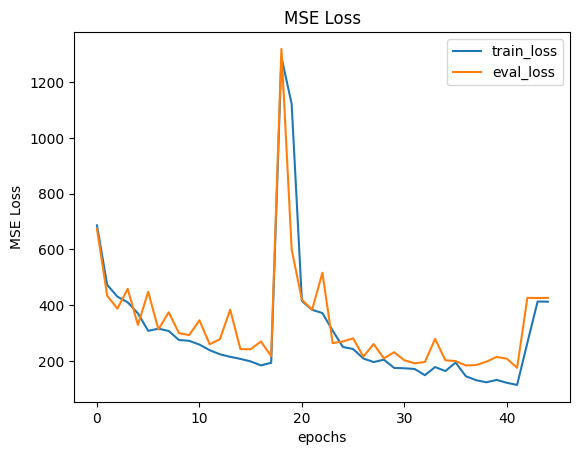

In [22]:
history_df['train_loss'].plot()
history_df['eval_loss'].plot()
plt.title("MSE Loss")
plt.ylabel("MSE Loss")
plt.xlabel("epochs")
plt.legend()

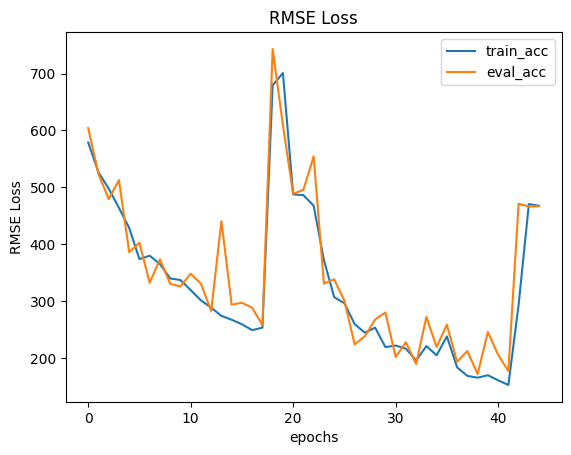

In [23]:
history_df['train_acc'].plot()
history_df['eval_acc'].plot()
plt.title("RMSE Loss")
plt.ylabel("RMSE Loss")
plt.xlabel("epochs")
plt.legend()